## Hyperparameter Tuning: Skip 3

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Conv1D, GlobalMaxPooling1D
from keras.optimizers import Adam

# Load datasets
tf_mini = pd.read_csv('/content/Project/tf_mini.csv')
log_mini = pd.read_csv('/content/Project/log_mini.csv')

# Merge datasets on track_id
merged_data = pd.merge(log_mini, tf_mini, left_on='track_id_clean', right_on='track_id')

# Print out column types to determine whether one-hot encoding is necessary or not
print(merged_data.dtypes)

session_id                          object
session_position                     int64
session_length                       int64
track_id_clean                      object
skip_1                                bool
skip_2                                bool
skip_3                                bool
not_skipped                           bool
context_switch                       int64
no_pause_before_play                 int64
short_pause_before_play              int64
long_pause_before_play               int64
hist_user_behavior_n_seekfwd         int64
hist_user_behavior_n_seekback        int64
hist_user_behavior_is_shuffle         bool
hour_of_day                          int64
date                                object
premium                               bool
context_type                        object
hist_user_behavior_reason_start     object
hist_user_behavior_reason_end       object
track_id                            object
duration                           float64
release_yea

In [3]:
# Change 'date' to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek
merged_data['month'] = merged_data['date'].dt.month
merged_data['duration'] = merged_data['duration'].astype(float)

# One-hot encode 'object' columns
categorical_columns = ['mode', 'context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming merged_data is your DataFrame and categorical_columns is the list of your categorical columns
encoder = OneHotEncoder(sparse_output=False)  # Note: 'sparse_output' replaces 'sparse'
merged_data_encoded = encoder.fit_transform(merged_data[categorical_columns])

# Use get_feature_names_out for newer versions of scikit-learn
merged_data_encoded_df = pd.DataFrame(merged_data_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Drop original categorical columns and concatenate the one-hot encoded columns
merged_data = merged_data.drop(categorical_columns, axis=1)
merged_data = pd.concat([merged_data, merged_data_encoded_df], axis=1)


In [4]:
# Drop origional categorical columns and other 'object' columns that do not provide useful information
merged_data = merged_data.drop(['session_id', 'track_id', 'track_id_clean', 'date'], axis=1)

In [5]:
print(merged_data.dtypes)

session_position                             int64
session_length                               int64
skip_1                                        bool
skip_2                                        bool
skip_3                                        bool
                                            ...   
hist_user_behavior_reason_end_endplay      float64
hist_user_behavior_reason_end_fwdbtn       float64
hist_user_behavior_reason_end_logout       float64
hist_user_behavior_reason_end_remote       float64
hist_user_behavior_reason_end_trackdone    float64
Length: 69, dtype: object


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

# Convert boolean target variable to an integer (0 or 1)
# False = 0, True = 1
merged_data['skipped'] = merged_data['skip_3'].astype(int)

# Separate the features and the target variable
X = merged_data.drop(['skip_1', 'skip_2', 'skip_3','not_skipped', 'skipped'], axis=1)  # Features
y = merged_data['skipped']  # Target variable -> skip_1

In [7]:
# Standardize the features (since features are all numerical and on different scales)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.5 MB/s eta 0:00:00


In [9]:
import shutil
import os

dir_path = 'my_dir'

# Check if the directory exists
if os.path.exists(dir_path) and os.path.isdir(dir_path):
    # Delete the directory and all its contents
    shutil.rmtree(dir_path)
    print(f"Deleted directory: {dir_path}")
else:
    print(f"The directory {dir_path} does not exist.")

The directory my_dir does not exist.


## Hyperparameter Tuning with Keras Tuner

In [10]:
import kerastuner as kt
import keras
from keras import layers

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32) if hp else 128,
                           activation='relu', input_shape=(X_train.shape[1],)))
    # model = Sequential()
    #model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   # activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 02m 24s]
val_accuracy: 0.981869637966156

Best val_accuracy So Far: 0.9839916825294495
Total elapsed time: 00h 31m 14s


In [11]:
print("Best Hyperparameters:", best_hps)

Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7bbbfea71ae0>


### Implement Callbacks (Early Stopping)

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the CustomEarlyStopping class
class CustomEarlyStopping(EarlyStopping):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stopped_epoch = 0

    def on_train_end(self, logs=None):
        super().on_train_end(logs)
        # Use the `stopped_epoch` attribute from the EarlyStopping base class
        self.stopped_epoch = self.stopped_epoch or self.stopped_epoch

# Create an instance of CustomEarlyStopping
early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, verbose=1)

# ModelCheckpoint to save the best model
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

# Assuming build_model is a function that returns a compiled model
model = build_model(best_hps)  # Create the model using your build_model function

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
1679/1679 [==============================] - 9s 5ms/step - loss: 0.1034 - accuracy: 0.9738 - val_loss: 0.0725 - val_accuracy: 0.9817
Epoch 2/50
  49/1679 [..............................] - ETA: 5s - loss: 0.0914 - accuracy: 0.9777

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1679/1679 [==============================] - 6s 4ms/step - loss: 0.0795 - accuracy: 0.9809 - val_loss: 0.0726 - val_accuracy: 0.9824
Epoch 3/50
1679/1679 [==============================] - 7s 4ms/step - loss: 0.0768 - accuracy: 0.9815 - val_loss: 0.0701 - val_accuracy: 0.9830
Epoch 4/50
1679/1679 [==============================] - 6s 3ms/step - loss: 0.0750 - accuracy: 0.9820 - val_loss: 0.0693 - val_accuracy: 0.9837
Epoch 5/50
1679/1679 [==============================] - 7s 4ms/step - loss: 0.0730 - accuracy: 0.9821 - val_loss: 0.0726 - val_accuracy: 0.9832
Epoch 6/50
1679/1679 [==============================] - 6s 3ms/step - loss: 0.0722 - accuracy: 0.9823 - val_loss: 0.0715 - val_accuracy: 0.9833
Epoch 7/50
1679/1679 [==============================] - 7s 4ms/step - loss: 0.0716 - accuracy: 0.9827 - val_loss: 0.0697 - val_accuracy: 0.9835
Epoch 8/50
1679/1679 [==============================] - 7s 4ms/step - loss: 0.0714 - accuracy: 0.9827 - val_loss: 0.0729 - val_accuracy: 0.9835
Epo

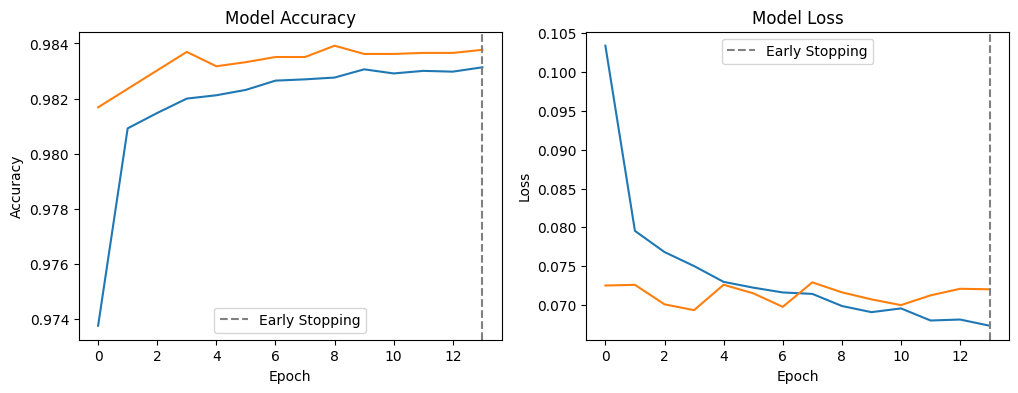

In [13]:
# Visualize the history of the model (plot model loss and model accuracy)
import matplotlib.pyplot as plt

stopped_epoch = early_stopping.stopped_epoch

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
if stopped_epoch:
    plt.axvline(x=stopped_epoch, color='gray', linestyle='--', label='Early Stopping')
    plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
if stopped_epoch:
    plt.axvline(x=stopped_epoch, color='gray', linestyle='--', label='Early Stopping')
    plt.legend()

plt.show()

In [14]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.2 MB/s eta 0:00:00


In [15]:
# To get a list of all column names from the DataFrame
feature_names = merged_data.columns.tolist()
#feature_names = ['skip_1', 'skip_2', 'skip_3']

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


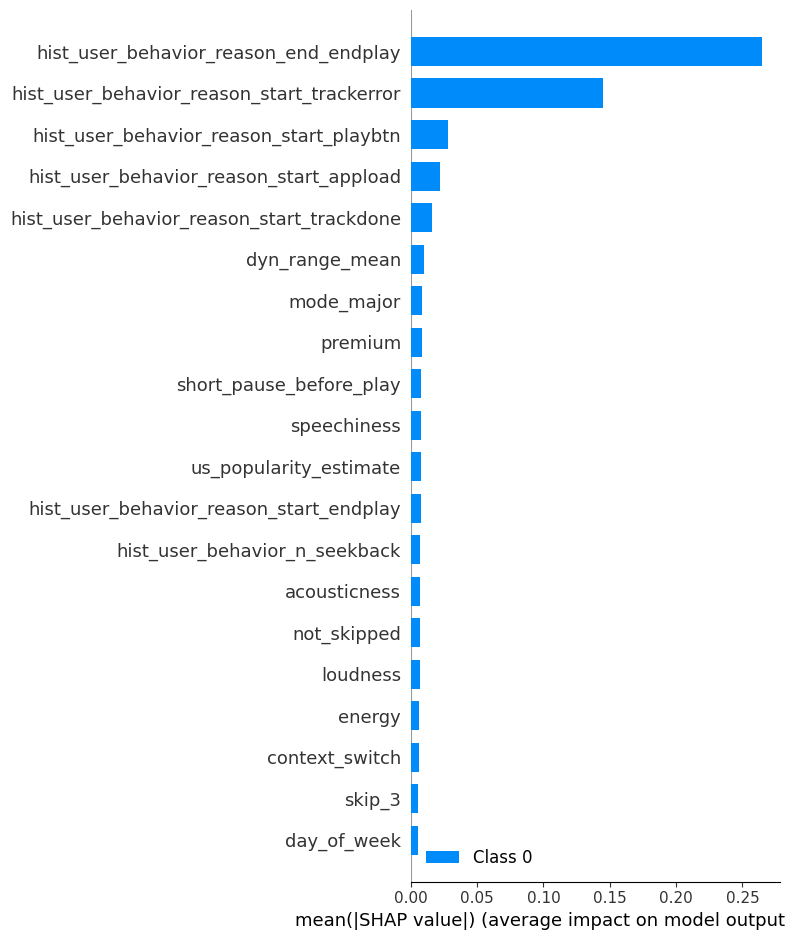

In [16]:
import shap

# Load the best model
model = keras.models.load_model('best_model.h5')

# Explain the model's predictions using SHAP
explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:100])

# Plot the SHAP values
shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)

## Let us conduct some deeper analysis...

## 1. Refine Model Architecture

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 2. Learning rate schedule to potentially improve training dynamics

In [18]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])


Epoch 1/50
1679/1679 [==============================] - 12s 6ms/step - loss: 0.1288 - accuracy: 0.9633 - val_loss: 0.0767 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 2/50
1679/1679 [==============================] - 9s 5ms/step - loss: 0.0882 - accuracy: 0.9793 - val_loss: 0.0744 - val_accuracy: 0.9818 - lr: 0.0010
Epoch 3/50
1679/1679 [==============================] - 8s 5ms/step - loss: 0.0825 - accuracy: 0.9803 - val_loss: 0.0724 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 4/50
1679/1679 [==============================] - 10s 6ms/step - loss: 0.0813 - accuracy: 0.9805 - val_loss: 0.0718 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 5/50
1679/1679 [==============================] - 7s 4ms/step - loss: 0.0804 - accuracy: 0.9805 - val_loss: 0.0714 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 6/50
1679/1679 [==============================] - 11s 7ms/step - loss: 0.0782 - accuracy: 0.9812 - val_loss: 0.0704 - val_accuracy: 0.9828 - lr: 0.0010
Epoch 7/50
1679/1679 [==============================] -

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


1679/1679 [==============================] - 9s 6ms/step - loss: 0.0750 - accuracy: 0.9817 - val_loss: 0.0695 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 11/50
1679/1679 [==============================] - 7s 4ms/step - loss: 0.0754 - accuracy: 0.9817 - val_loss: 0.0692 - val_accuracy: 0.9836 - lr: 0.0010
Epoch 12/50
1679/1679 [==============================] - 10s 6ms/step - loss: 0.0754 - accuracy: 0.9817 - val_loss: 0.0691 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 13/50
1679/1679 [==============================] - 9s 5ms/step - loss: 0.0747 - accuracy: 0.9819 - val_loss: 0.0695 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 14/50
1679/1679 [==============================] - 8s 5ms/step - loss: 0.0744 - accuracy: 0.9820 - val_loss: 0.0688 - val_accuracy: 0.9841 - lr: 0.0010
Epoch 15/50
1679/1679 [==============================] - 9s 5ms/step - loss: 0.0746 - accuracy: 0.9819 - val_loss: 0.0684 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 16/50
1679/1679 [==============================] - 8s 5ms

## 3. Hyperparameter Tuning

In [19]:
import tensorflow as tf
from tensorflow import keras

!pip install keras-tuner
import kerastuner
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

In [20]:
# Initialize Tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='spotify_skip_behavior'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping])

# Best hyperparameter
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Trial 30 Complete [00h 01m 57s]
val_accuracy: 0.9816834926605225

Best val_accuracy So Far: 0.9841033220291138
Total elapsed time: 00h 32m 23s
Epoch 1/50
1679/1679 [==============================] - 9s 5ms/step - loss: 0.1095 - accuracy: 0.9724 - val_loss: 0.0757 - val_accuracy: 0.9811
Epoch 2/50
1679/1679 [==============================] - 7s 4ms/step - loss: 0.0808 - accuracy: 0.9807 - val_loss: 0.0741 - val_accuracy: 0.9822
Epoch 3/50
1679/1679 [==============================] - 9s 5ms/step - loss: 0.0771 - accuracy: 0.9812 - val_loss: 0.0715 - val_accuracy: 0.9825
Epoch 4/50
1679/1679 [==============================] - 8s 5ms/step - loss: 0.0747 - accuracy: 0.9818 - val_loss: 0.0714 - val_accuracy: 0.9828
Epoch 5/50
1679/1679 [==============================] - 9s 5ms/step - loss: 0.0735 - accuracy: 0.9821 - val_loss: 0.0704 - val_accuracy: 0.9832
Epoch 6/50
1679/1679 [==============================] - 10s 6ms/step - loss: 0.0720 - accuracy: 0.9822 - val_loss: 0.0690 - val_accuracy:

## 4. Model Evaluation with ROC Curve and AUC

1050/1050 [==============================] - 2s 2ms/step


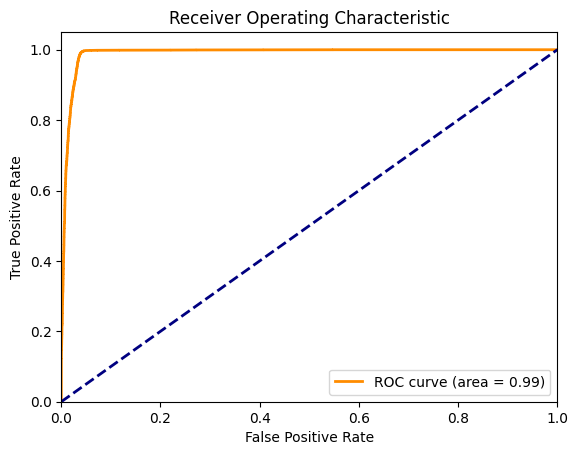

In [21]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 5. Use SHAP to interpret model's predictions

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


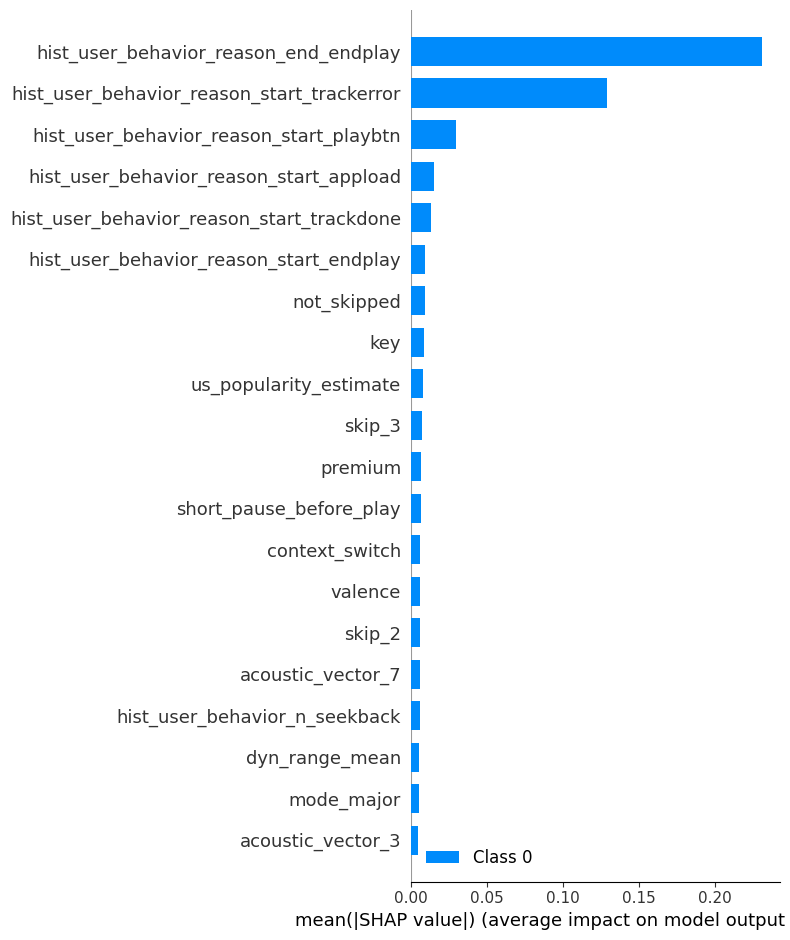

In [22]:
import shap

explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:100])

shap.summary_plot(shap_values, X_test[:100], feature_names=feature_names)